In [1]:
# FIFA 20 Analysis with PCA and Clustering

# Install required libraries
# !pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 1. Load and Inspect Data

In [2]:
# Load the dataset
file_path = '../data/players_20.csv'  # Update with your file path
fifa20_data = pd.read_csv(file_path)

# Inspect the dataset
print("Dataset Shape:", fifa20_data.shape)
fifa20_data.head()


Dataset Shape: (18278, 104)


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,

## 2. Data Cleaning and Preprocessing

In [10]:
# Check for missing values
missing_data = fifa20_data.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_data[missing_data > 0])

# Columns to drop based on irrelevance or redundancy
to_drop = [
    'sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 
    'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags',
    'team_position', 'team_jersey_number', 'loaned_from', 'joined', 
    'contract_valid_until', 'nation_position', 'nation_jersey_number', 
    'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
    'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 
    'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'
]

# Drop unnecessary columns (only if they exist)
columns_to_drop = [col for col in to_drop if col in fifa20_data.columns]
fifa20_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Fill missing values
fifa20_data.fillna(0, inplace=True)

# Select numerical columns for analysis
numerical_data = fifa20_data.select_dtypes(include=[np.number])

print("Cleaned Dataset Shape:", fifa20_data.shape)


Missing values per column:
 Series([], dtype: int64)
Cleaned Dataset Shape: (18278, 59)


## 3. Exploratory Data Analysis (EDA)

In [11]:
# Inspect the Available Columns
print(fifa20_data.columns)

Index(['age', 'height_cm', 'weight_kg', 'club', 'overall', 'potential',
       'value_eur', 'wage_eur', 'player_positions', 'preferred_foot',
       'international_reputation', 'weak_foot', 'skill_moves', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_c

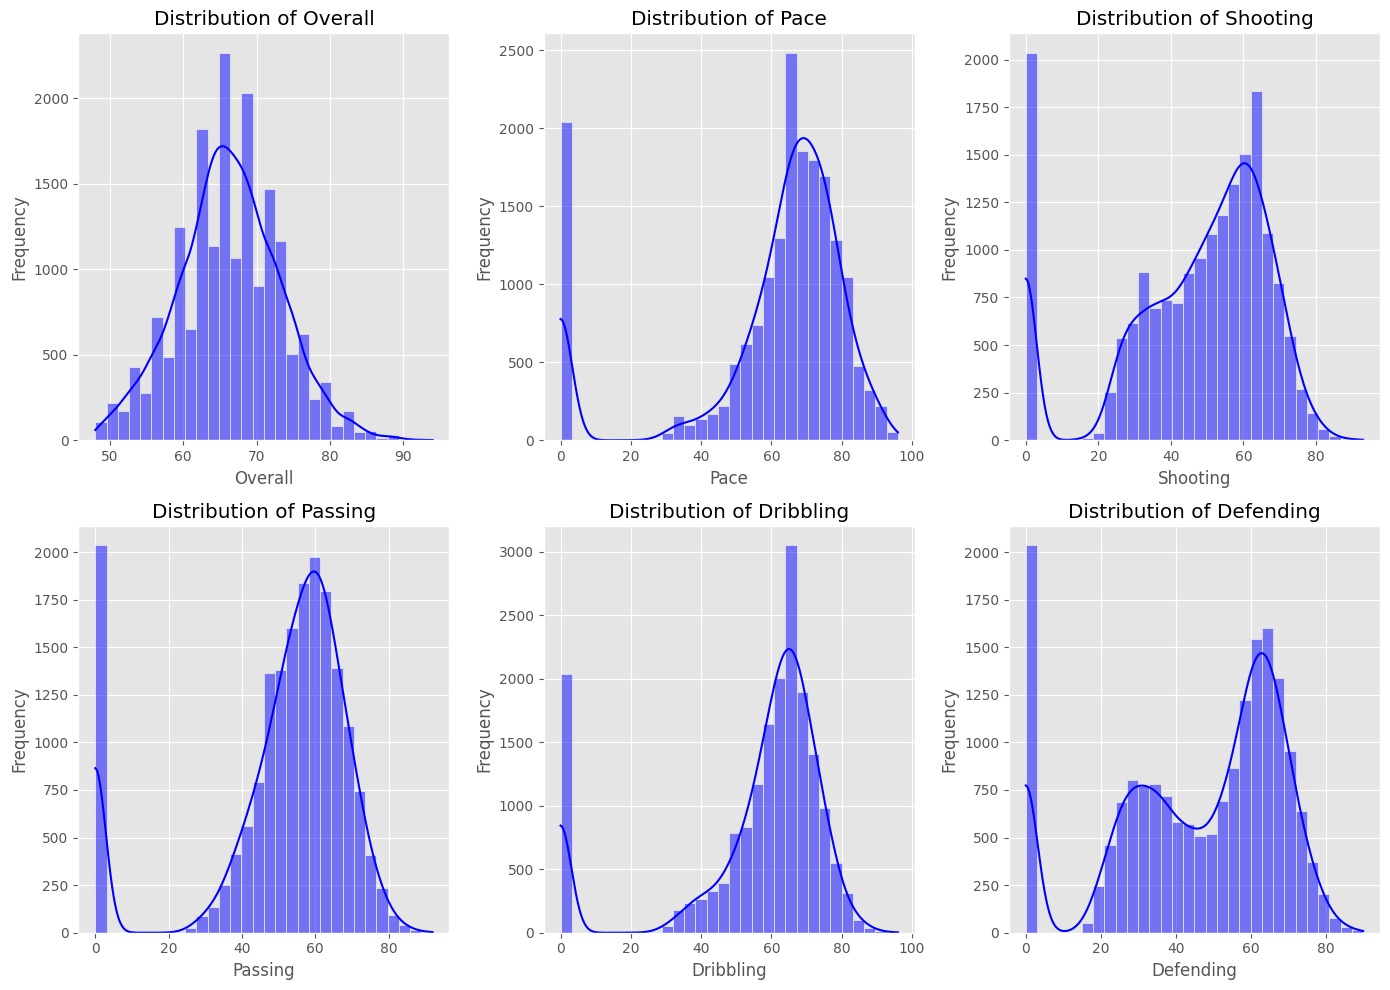

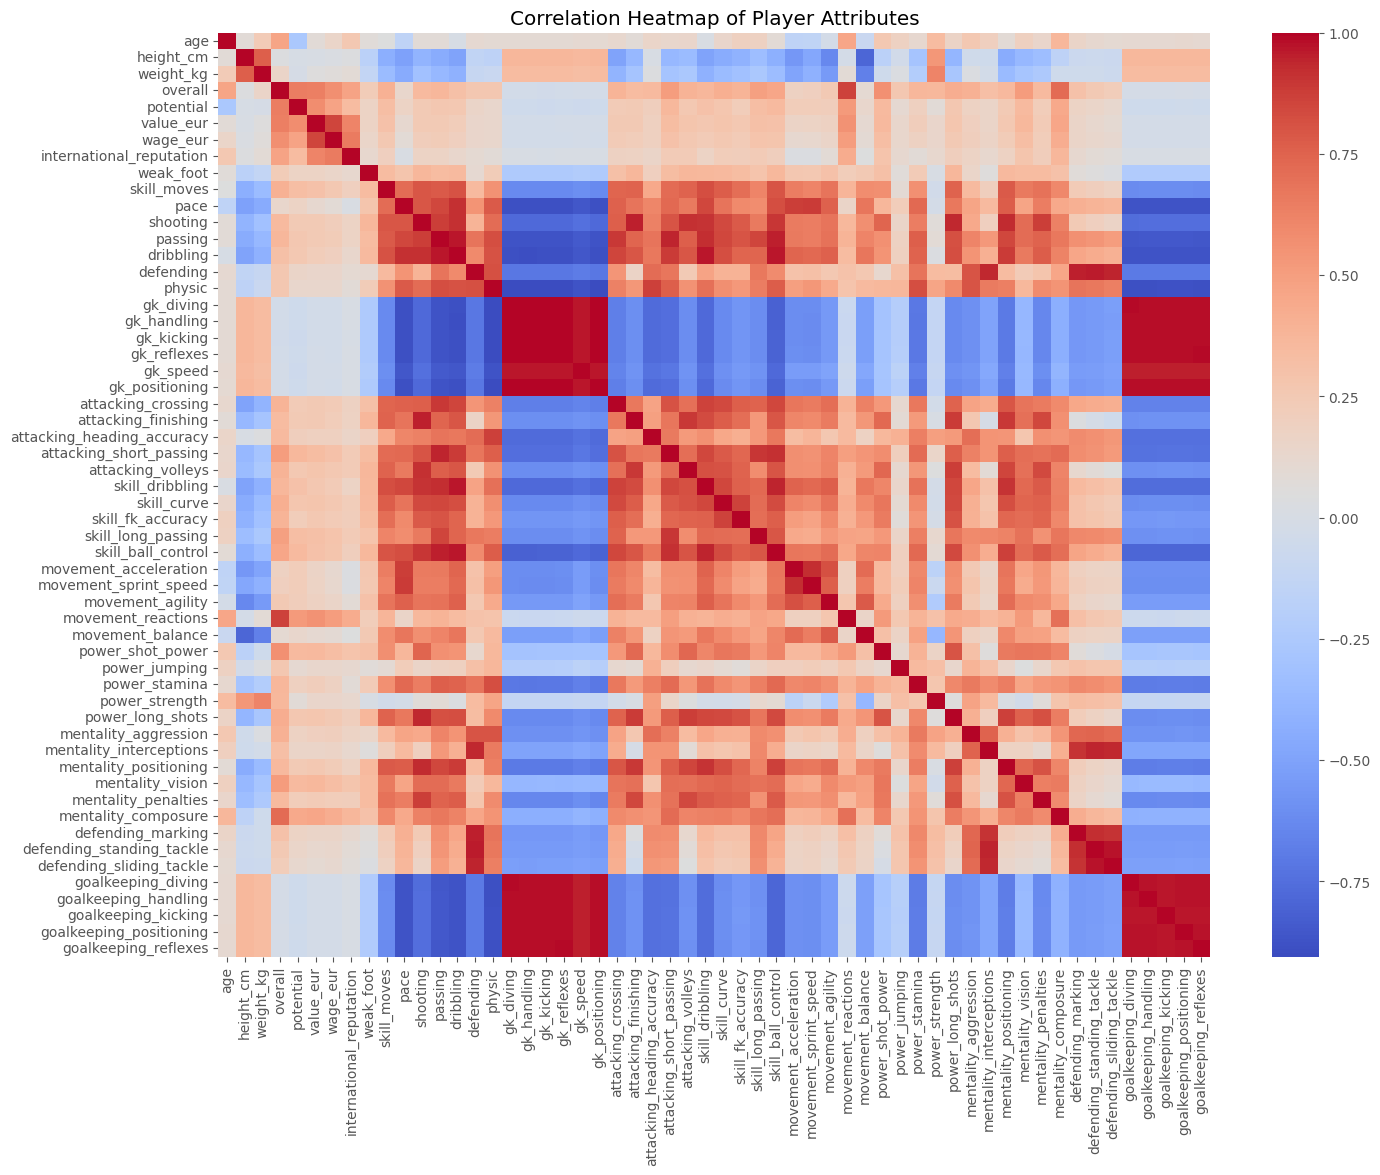

In [13]:
# Distribution of Key Attributes
# Choose attributes relevant to the cleaned dataset
key_attributes = ['overall', 'pace', 'shooting', 'passing', 'dribbling', 'defending']

plt.figure(figsize=(14, 10))
for i, attr in enumerate(key_attributes, 1):
    plt.subplot(2, 3, i)  # Adjusting for the number of attributes
    sns.histplot(fifa20_data[attr], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {attr.capitalize()}')
    plt.xlabel(attr.capitalize())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation Matrix
# Generate a correlation matrix for the numerical data
plt.figure(figsize=(16, 12))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Player Attributes')
plt.show()


## 4. Standardize the Data

In [15]:
# Standardize numerical data for PCA or clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

print("Data has been cleaned and standardized. Shape:", scaled_data.shape)

Data has been cleaned and standardized. Shape: (18278, 56)


## 5. Principal Component Analysis (PCA)

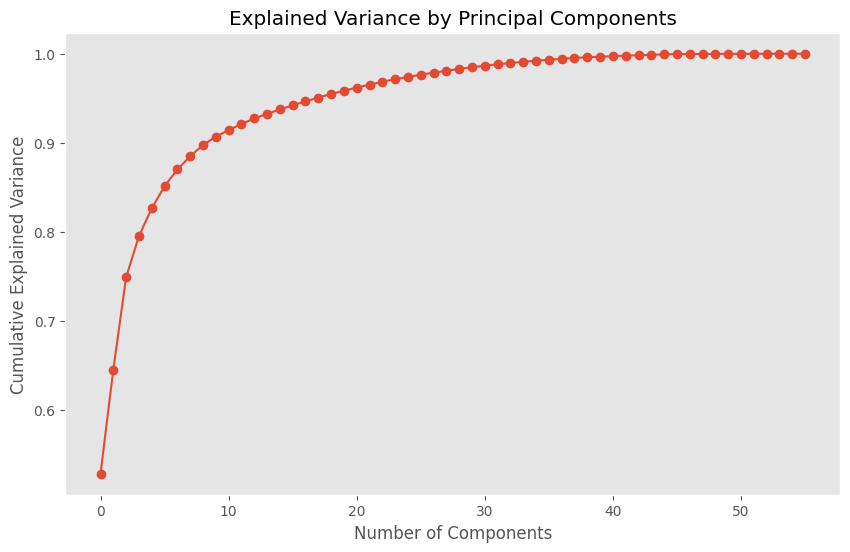

Number of components to retain 90% variance: 10


In [16]:
# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Select optimal number of components (e.g., 90% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(scaled_data)


## 6. Determine Optimal Number of Clusters
### Elbow Method

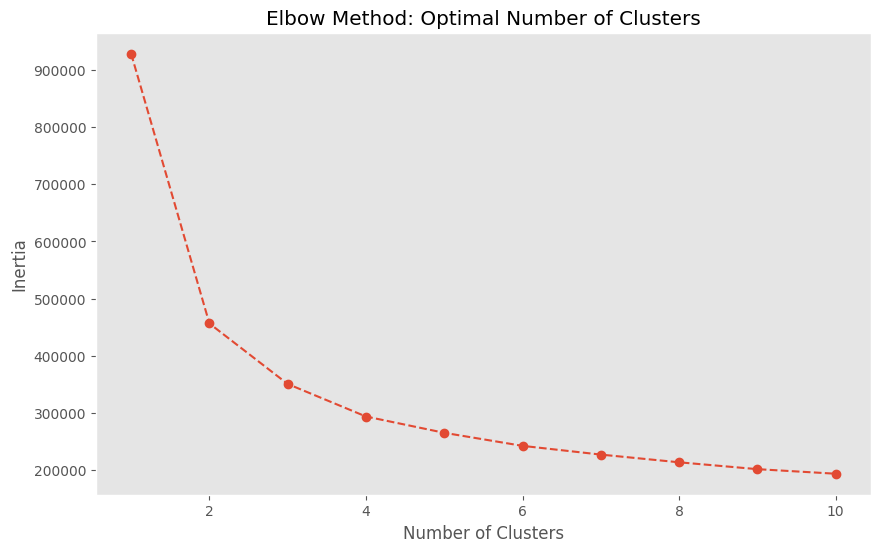

In [17]:
# Elbow Method to determine the optimal number of clusters
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()


### Silhouette Score

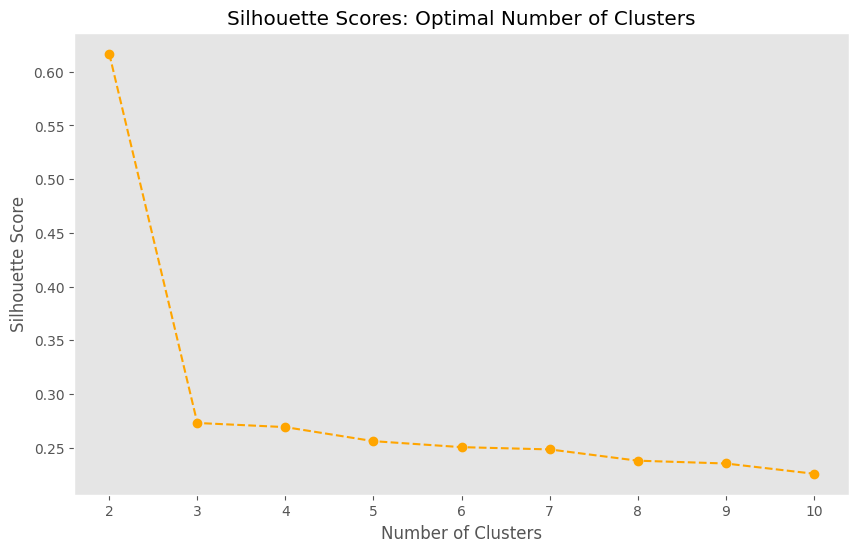

The optimal number of clusters based on silhouette score is: 2


In [18]:
# Silhouette Scores for different numbers of clusters
silhouette_scores = []

for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Scores: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Find the best number of clusters based on the highest silhouette score
optimal_silhouette_clusters = range(2, 11)[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters based on silhouette score is: {optimal_silhouette_clusters}")


## 7. Perform Clustering
### Apply K-Means Clustering

In [19]:
from sklearn.cluster import KMeans

optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Add cluster labels to the original data
fifa20_data['Cluster'] = clusters

print("Clustering completed. Cluster labels added to the dataset.")


Clustering completed. Cluster labels added to the dataset.


### Visualize Clusters Using PCA Components

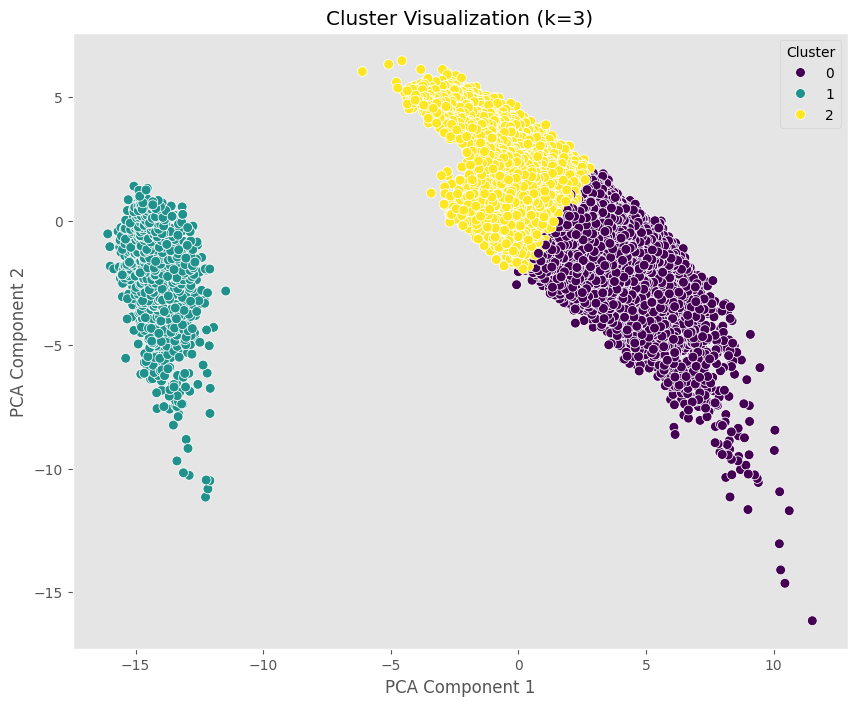

In [20]:
# Visualize Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    hue=clusters,
    palette='viridis',
    s=50,
    legend='full'
)
plt.title(f'Cluster Visualization (k={optimal_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


## 8. Analyze Clusters

Cluster Attribute Comparisons:
           overall       pace   shooting    passing  dribbling  defending
Cluster                                                                  
0        70.116571  71.784449  62.048552  64.086900  69.608420  49.471326
1        64.796660   0.000000   0.000000   0.000000   0.000000   0.000000
2        62.348153  63.187557  41.521841  49.659365  54.709916  53.854828


C:\Users\Admin\AppData\Local\Temp\ipykernel_9064\3575672566.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fifa20_data, x='Cluster', palette='viridis')


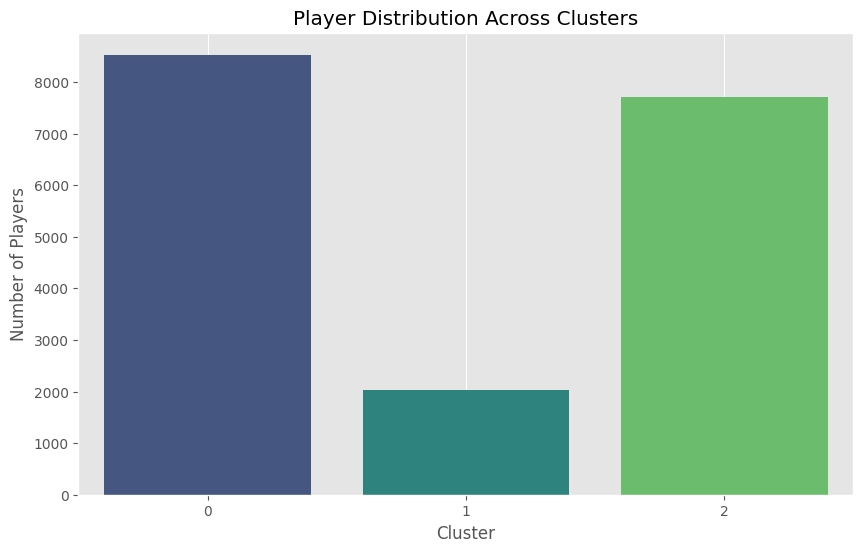

In [21]:
# Analyze clusters
cluster_means = fifa20_data.groupby('Cluster')[key_attributes].mean()
print("Cluster Attribute Comparisons:")
print(cluster_means)

# Cluster distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=fifa20_data, x='Cluster', palette='viridis')
plt.title('Player Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Players')
plt.grid()
plt.show()

In [ ]:
cluster_summary = fifa20_data.groupby('Cluster').mean()
print(cluster_summary)


## 9. Save Results

In [22]:
# Save the clustered data to CSV for further use
fifa20_data.to_csv('fifa20_clusters.csv', index=False)
print("Clustered data saved to 'fifa20_clusters.csv'")


Clustered data saved to 'fifa20_clusters.csv'
